# Lab 6: Variable Selection and Regularization
Use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

In [195]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer, make_column_selector
df = pd.read_csv("Hitters.csv")
df.head()

#How many null values are in the salary column?
#Because we are cross-validating in this lab, we need to drop the null values. 
null_count = df['Salary'].isnull().sum()
print(null_count)

59
59


In [196]:
#Clean the data
df = df.dropna()

## Part 1: Different Model Specs
### A. Regression without regularization

Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

In [197]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_1 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

#coefficients
#ChatGPT helped me put the top 5 highest coefficients in a dataframe.
lr_pipeline_1.fit(X, y)
lr_coef = lr_pipeline_1.named_steps['linear_regression'].coef_
feature_names = lr_pipeline_1.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
coeff_df.head(5)

,Feature,Coefficient
16,standardize__CRuns,480.747135
7,standardize__Hits,337.830479
17,standardize__CRBI,260.689886
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617


Interpret a few of the most important coefficents: 

1. standardize__CRuns (480.75)
A one standard deviation increase in the number of runs scored during the player's career is associated with an increase of approximately $480,750 in the player's salary.

2. standardize__Hits (337.83)
A one standard deviation increase in the number of hits in 1986 is associated with an increase of approximately $337,830 in a player's salary.

3. standardize__CRBI (260.69)
A one standard deviation increase in the number of runs batted in during the player's career is associated with an increase of approximately $260,690 in a player's salary.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [198]:
scores = cross_val_score(lr_pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error')
-scores.mean()

121136.31031816886

Based on our best model, the MSE we would expect if we used this pipeline to predict 1989 salaries would be 121136.31

### B. Ridge regression

In [199]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha = 1))] 
)

#Tuning
degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_2, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

ridge_MTS = gscv_fitted.cv_results_['mean_test_score']
ridgeMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(ridgeMSE) #Should I change these values to be positive?

#ChatGPT helped me put the top 5 highest coefficients in a dataframe.

#Based on these results I will pick model 3 as it has the lowest MSE if I were to multiply the scores by -1
lr_pipeline_2.fit(X, y)
lr_coef = lr_pipeline_2.named_steps['ridge_regression'].coef_
feature_names = lr_pipeline_2.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.
scores = cross_val_score(lr_pipeline_2, X, y, cv=5, scoring='neg_mean_squared_error')
print(-scores.mean())


   degrees         scores
0    0.001  121124.458592
1    0.010  121022.903286
2    0.100  120343.621067
3    1.000  119144.432677
4   10.000  119348.984776
               Feature  Coefficient
16  standardize__CRuns   320.412169
7    standardize__Hits   296.645050
17   standardize__CRBI   160.386784
14  standardize__CHits   126.659607
11  standardize__Walks   124.407173
119144.43267691578
   degrees         scores
0    0.001  121124.458592
1    0.010  121022.903286
2    0.100  120343.621067
3    1.000  119144.432677
4   10.000  119348.984776
               Feature  Coefficient
16  standardize__CRuns   320.412169
7    standardize__Hits   296.645050
17   standardize__CRBI   160.386784
14  standardize__CHits   126.659607
11  standardize__Walks   124.407173
119144.43267691578


Interpret a few of the most important coefficents: 

1. standardize__CRuns (320.41)
A one standard deviation increase in the number of runs scored during the player's career is associated with an increase of approximately $320,412 in the player's salary.

2. standardize__Hits (296.65)
A one standard deviation increase in the number of hits in 1986 is associated with an increase of approximately $296,645 in a player's salary.

3. standardize__CRBI (160.39)
A one standard deviation increase in the number of runs batted in during the player's career is associated with an increase of approximately $160,387 in a player's salary.

Based on our best model, the MSE we would expect if we used this pipeline to predict 1989 salaries would be 119144.43

### C. Lasso regression

In [200]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(max_iter=1000000))] 
)

#Use cross-validation to tune the hyperparameter
degrees = {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(lr_pipeline_3, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

lasso_MTS = gscv_fitted.cv_results_['mean_test_score']
lassoMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(lassoMSE)

#Based on these results I will pick model 3 as it has the lowest MSE if I were to multiply the scores by -1

#ChatGPT helped me put the top 5 highest coefficients in a dataframe.
lr_pipeline_3.fit(X, y)
lr_coef = lr_pipeline_3.named_steps['Lasso'].coef_
feature_names = lr_pipeline_3.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.
scores = cross_val_score(lr_pipeline_3, X, y, cv=5, scoring='neg_mean_squared_error')
print(-scores.mean())

   degrees         scores
0    0.001  121132.276754
1    0.010  121096.159270
2    0.100  120758.508162
3    1.000  119758.108873
4   10.000  121828.141333
                Feature  Coefficient
16   standardize__CRuns   375.565519
7     standardize__Hits   304.359509
17    standardize__CRBI   192.610892
11   standardize__Walks   120.695275
2   dummify__Division_E   114.412951
119758.10887295291
   degrees         scores
0    0.001  121132.276754
1    0.010  121096.159270
2    0.100  120758.508162
3    1.000  119758.108873
4   10.000  121828.141333
                Feature  Coefficient
16   standardize__CRuns   375.565519
7     standardize__Hits   304.359509
17    standardize__CRBI   192.610892
11   standardize__Walks   120.695275
2   dummify__Division_E   114.412951
119758.10887295291


Interpret a few of the most important coefficents: 

1. standardize__CRuns (375.57)
A one standard deviation increase in the number of runs scored during the player's career is associated with an increase of approximately $375,566 in the player's salary.

2. standardize__Hits (304.36)
A one standard deviation increase in the number of hits in 1986 is associated with an increase of approximately $304,360 in a player's salary.

3. standardize__CRBI (192.61)
A one standard deviation increase in the number of runs batted in during the player's career is associated with an increase of approximately $192,611 in a player's salary.

Based on our best model, the MSE we would expect if we used this pipeline to predict 1989 salaries would be 119758.11

### D. Elastic Net

In [201]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", 
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

lr_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(max_iter=1000000))] 
)

#Use cross-validation to tune the hyperparameter
degrees = {'ElasticNet__alpha': [0.001, 0.01, 0.1, 1, 10], 'ElasticNet__l1_ratio': [0.25, 0.5, 0.75, 1]}

gscv = GridSearchCV(lr_pipeline_4, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

results_df = pd.DataFrame({
    'alpha': gscv_fitted.cv_results_['param_ElasticNet__alpha'],
    'l1_ratio': gscv_fitted.cv_results_['param_ElasticNet__l1_ratio'],
    'mean_test_score': gscv_fitted.cv_results_['mean_test_score']*-1
})

print(results_df)

#Our best model: 4    0.01     0.25   -119009.799554
new_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(alpha=0.01, l1_ratio=0.25))] 
)

#Fit the pipeline with your chosen to the full dataset, and interpret a few of the most important coefficients.
#ChatGPT helped me put the top 5 highest coefficients in a dataframe.
new_pipeline.fit(X, y)
lr_coef = new_pipeline.named_steps['ElasticNet'].coef_
feature_names = new_pipeline.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

#Report the MSE you would expect if you used this pipeline to predict 1989 salaries.
scores = cross_val_score(new_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print(-scores.mean())

    alpha l1_ratio  mean_test_score
0   0.001     0.25    120085.311929
1   0.001      0.5    120313.824505
2   0.001     0.75    120637.588073
3   0.001        1    121132.276754
4    0.01     0.25    119009.799554
5    0.01      0.5    119123.793086
6    0.01     0.75    119404.285345
7    0.01        1    121096.159270
8     0.1     0.25    119636.170227
9     0.1      0.5    119381.375571
10    0.1     0.75    119036.413543
11    0.1        1    120758.508162
12      1     0.25    121374.333746
13      1      0.5    120775.685401
14      1     0.75    120356.595998
15      1        1    119758.108873
16     10     0.25    144021.731082
17     10      0.5    136766.425349
18     10     0.75    128407.505050
19     10        1    121828.141333
               Feature  Coefficient
7    standardize__Hits   266.646982
16  standardize__CRuns   254.831964
17   standardize__CRBI   132.427745
14  standardize__CHits   125.875104
11  standardize__Walks   116.406884
119009.79955442324
    alpha

Interpret a few of the most important coefficents: 

1. standardize__Hits (266.65)
A one standard deviation increase in the number of runs scored during the player's career is associated with an increase of approximately $266,647 in the player's salary.

2. standardize__CRuns (254.83)
A one standard deviation increase in the number of hits in 1986 is associated with an increase of approximately $254,832 in a player's salary.

3. standardize__CRBI (132.43)
A one standard deviation increase in the number of runs batted in during the player's career is associated with an increase of approximately $132,428 in a player's salary.

Based on our best model, the MSE we would expect if we used this pipeline to predict 1989 salaries would be 119009.80

## Part 2: Variable Selection

Based on the above results, decide on:

Which numeric variable is most important: **CRuns**

Which five numeric variables are most important: **CRuns, Hits, CRBI, Walks, CHits**

Which categorical variable is most important: **Division**

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

### Linear Model

In [202]:
X = df[["CRuns"]]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ["CRuns"])],
    remainder="passthrough"
)

lr_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

mse_linear_cruns = -cross_val_score(lr_pipeline_5, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_linear_cruns)


143812.9359162973
143812.9359162973


In [203]:
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits']]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])],
    remainder="passthrough"
)

lr_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
)

mse_linear_top5 = -cross_val_score(lr_pipeline_6, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_linear_top5)

126047.77085146765
126047.77085146765


In [204]:
#Interaction
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits', 'Division']]
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop = 'first'), ["Division"]),
    ("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])
  ],
  remainder = "passthrough"
).set_output(transform="pandas")
#Need .set_output(transform="pandas") whenever we are doing interactions or multiple column transformers. 

ct_inter = ColumnTransformer(

  [

    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),

    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),

    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),

    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"]),

    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),

  ],

  remainder = "drop" #Is this right?

).set_output(transform="pandas")



lr_pipeline7 = Pipeline(

  [("preprocessing", ct),

  ("preprocessing2", ct_inter),

  ("linear_regression", LinearRegression())])

lr_pipeline7

scores = cross_val_score(lr_pipeline7, X, y, cv=5, scoring='neg_mean_squared_error').mean()*-1

print(scores)

lr_pipeline7.fit(X, y)
feature_names_ct_inter = lr_pipeline7.named_steps['preprocessing2'].get_feature_names_out()

# Create a DataFrame with only interaction coefficients
interaction_coefficients = coefficients[-len(feature_names_ct_inter):]  # Last section of coefficients from the interaction step

interaction_df = pd.DataFrame({
    'Feature': feature_names_ct_inter,
    'Coefficient': interaction_coefficients
    })
interaction_df

interaction_df = interaction_df.sort_values(by='Coefficient', ascending=False)
interaction_df


134896.0442674291
134896.0442674291


,Feature,Coefficient
19,interaction5__standardize__CHits dummify__Divi...,3.720902e+02
9,interaction3__standardize__CRBI,3.158890e+02
5,interaction2__standardize__Hits,1.121361e+02
13,interaction4__standardize__Walks,8.204653e+01
1,interaction__standardize__CRuns,6.957450e+01
4,interaction2__1,1.421085e-14
16,interaction5__1,0.000000e+00
12,interaction4__1,0.000000e+00
0,interaction__1,0.000000e+00
8,interaction3__1,-2.273737e-13


### Ridge Model

In [206]:
X = df[["CRuns"]]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ["CRuns"])],
    remainder="passthrough"
)

lr_pipeline_8 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

#Tuning
degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_8, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

ridge_MTS = gscv_fitted.cv_results_['mean_test_score']
ridgeMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(ridgeMSE) #Should I change these values to be positive?

new_pipeline_2 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)

mse_ridge_cruns = -cross_val_score(new_pipeline_2, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_ridge_cruns)

#Coefficients
new_pipeline_2.fit(X, y)
lr_coef = new_pipeline_2.named_steps['ridge_regression'].coef_
feature_names = new_pipeline_2.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

   degrees         scores
0    0.001  143812.905015
1    0.010  143812.627051
2    0.100  143809.862456
3    1.000  143783.706854
4   10.000  143658.517369
143658.5173685888
              Feature  Coefficient
0  standardize__CRuns   244.071121
   degrees         scores
0    0.001  143812.905015
1    0.010  143812.627051
2    0.100  143809.862456
3    1.000  143783.706854
4   10.000  143658.517369
143658.5173685888
              Feature  Coefficient
0  standardize__CRuns   244.071121


In [207]:
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits']]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])],
    remainder="passthrough"
)

lr_pipeline_9 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

#Tuning
degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_9, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

ridge_MTS = gscv_fitted.cv_results_['mean_test_score']
ridgeMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(ridgeMSE) #Should I change these values to be positive?

new_pipeline_3 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)

mse_ridge_top5 = -cross_val_score(new_pipeline_3, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_ridge_top5)

#Coefficients
new_pipeline_3.fit(X, y)
lr_coef = new_pipeline_3.named_steps['ridge_regression'].coef_
feature_names = new_pipeline_3.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

   degrees         scores
0    0.001  126046.757841
1    0.010  126037.669848
2    0.100  125949.562233
3    1.000  125269.250471
4   10.000  123172.832275
123172.83227523179
              Feature  Coefficient
2   standardize__CRBI   126.472957
1   standardize__Hits   104.861189
3  standardize__Walks    69.846563
0  standardize__CRuns    57.286936
4  standardize__CHits    26.383317
   degrees         scores
0    0.001  126046.757841
1    0.010  126037.669848
2    0.100  125949.562233
3    1.000  125269.250471
4   10.000  123172.832275
123172.83227523179
              Feature  Coefficient
2   standardize__CRBI   126.472957
1   standardize__Hits   104.861189
3  standardize__Walks    69.846563
0  standardize__CRuns    57.286936
4  standardize__CHits    26.383317


In [208]:
#Interaction
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits', 'Division']]
y = df["Salary"]

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop = 'first'), ["Division"]),
    ("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])
  ],
  remainder = "passthrough"
).set_output(transform="pandas")
#Need .set_output(transform="pandas") whenever we are doing interactions or multiple column transformers. 

ct_inter = ColumnTransformer(

  [

    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),

    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),

    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),

    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"]),

    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),

  ],

  remainder = "drop" 

).set_output(transform="pandas")

lr_pipeline_10 = Pipeline(

  [("preprocessing", ct),

  ("preprocessing2", ct_inter),

  ("ridge_regression", Ridge())])

lr_pipeline_10

#Tuning
degrees = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_10, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

ridge_MTS = gscv_fitted.cv_results_['mean_test_score']
ridgeMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(ridgeMSE) #Should I change these values to be positive?

new_pipeline_4 = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_inter),
  ("ridge_regression", Ridge(alpha=10))]
)

mse_ridge_interaction = -cross_val_score(new_pipeline_4, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_ridge_interaction)

#Coefficients
new_pipeline_4.fit(X, y)
feature_names_ct_inter = new_pipeline_4.named_steps['preprocessing2'].get_feature_names_out()
ridge_coeff = new_pipeline_4.named_steps["ridge_regression"].coef_

# Create a DataFrame with only interaction coefficients
interaction_df = pd.DataFrame({
    'Feature': feature_names_ct_inter,
    'Coefficient': ridge_coeff
    })
interaction_df

interaction_df = interaction_df.sort_values(by='Coefficient', ascending=False)
interaction_df


   degrees         scores
0    0.001  134875.244943
1    0.010  134691.592069
2    0.100  133141.977056
3    1.000  126996.127537
4   10.000  120167.252960
120167.2529598724
   degrees         scores
0    0.001  134875.244943
1    0.010  134691.592069
2    0.100  133141.977056
3    1.000  126996.127537
4   10.000  120167.252960
120167.2529598724


,Feature,Coefficient
9,interaction3__standardize__CRBI,157.459941
5,interaction2__standardize__Hits,100.259869
13,interaction4__standardize__Walks,89.552809
17,interaction5__standardize__CHits,57.994893
1,interaction__standardize__CRuns,38.253567
19,interaction5__standardize__CHits dummify__Divi...,15.235975
16,interaction5__1,0.000000
12,interaction4__1,0.000000
0,interaction__1,0.000000
8,interaction3__1,0.000000


### Lasso Model

In [209]:
X = df[["CRuns"]]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ["CRuns"])],
    remainder="passthrough"
)

lr_pipeline_11 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha=1))]
)

#Tuning
degrees = {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_11, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

lasso_MTS = gscv_fitted.cv_results_['mean_test_score']
lassoMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(lassoMSE) 

new_pipeline_5 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha=10))]
)

mse_lasso_cruns = -cross_val_score(new_pipeline_5, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_lasso_cruns)

new_pipeline_5.fit(X, y)
lr_coef = new_pipeline_5.named_steps['Lasso'].coef_
feature_names = new_pipeline_5.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())


   degrees         scores
0    0.001  143812.923545
1    0.010  143812.812299
2    0.100  143811.709122
3    1.000  143801.606084
4   10.000  143793.449159
143793.4491585397
              Feature  Coefficient
0  standardize__CRuns   243.351392
   degrees         scores
0    0.001  143812.923545
1    0.010  143812.812299
2    0.100  143811.709122
3    1.000  143801.606084
4   10.000  143793.449159
143793.4491585397
              Feature  Coefficient
0  standardize__CRuns   243.351392


In [210]:
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits']]
y = df["Salary"]

ct = ColumnTransformer(
    [("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])],
    remainder="passthrough"
)

lr_pipeline_12 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha=1))]
)

#Tuning
degrees = {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_12, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

lasso_MTS = gscv_fitted.cv_results_['mean_test_score']
lassoMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(lassoMSE) #Should I change these values to be positive?

new_pipeline_6 = Pipeline(
  [("preprocessing", ct),
  ("Lasso", Lasso(alpha=10))]
)

mse_lasso_top5 = -cross_val_score(new_pipeline_6, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_lasso_top5)

new_pipeline_6.fit(X, y)
lr_coef = new_pipeline_6.named_steps['Lasso'].coef_
feature_names = new_pipeline_6.named_steps['preprocessing'].get_feature_names_out()

coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_coef
})
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print(coeff_df.head())

   degrees         scores
0    0.001  126046.974218
1    0.010  126040.459625
2    0.100  125915.368927
3    1.000  125054.550948
4   10.000  124607.075674
124607.07567424091
              Feature  Coefficient
2   standardize__CRBI   150.985939
1   standardize__Hits   104.194408
3  standardize__Walks    63.259990
0  standardize__CRuns    54.623935
4  standardize__CHits     0.000000
   degrees         scores
0    0.001  126046.974218
1    0.010  126040.459625
2    0.100  125915.368927
3    1.000  125054.550948
4   10.000  124607.075674
124607.07567424091
              Feature  Coefficient
2   standardize__CRBI   150.985939
1   standardize__Hits   104.194408
3  standardize__Walks    63.259990
0  standardize__CRuns    54.623935
4  standardize__CHits     0.000000


In [211]:
#Interaction
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits', 'Division']]
y = df["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop = 'first'), ["Division"]),
    ("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])
  ],
  remainder = "drop"
).set_output(transform="pandas")
#Need .set_output(transform="pandas") whenever we are doing interactions or multiple column transformers. 

ct_inter = ColumnTransformer(

  [

    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),

    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),

    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),

    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"]),

    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),

  ],

  remainder = "drop" #Is this right?

)

lr_pipeline_13 = Pipeline(

  [("preprocessing", ct),

  ("preprocessing2", ct_inter),

  ("Lasso", Lasso(max_iter=1000000))])

lr_pipeline_13

#Tuning
degrees = {'Lasso__alpha': [0.001, 0.01, 0.1, 1, 10]}

#Cross Validation
gscv = GridSearchCV(lr_pipeline_13, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

lasso_MTS = gscv_fitted.cv_results_['mean_test_score']
lassoMSE = pd.DataFrame(data = {"degrees": [0.001, 0.01, 0.1, 1, 10], "scores": gscv_fitted.cv_results_['mean_test_score']*-1})
print(lassoMSE) #Should I change these values to be positive?

new_pipeline_7 = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_inter),
  ("Lasso", Lasso(alpha=10))]
)

mse_lasso_interaction = -cross_val_score(new_pipeline_7, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_lasso_interaction)


#Coefficients
new_pipeline_7.fit(X, y)
feature_names_ct_inter = new_pipeline_7.named_steps['preprocessing2'].get_feature_names_out()
lasso_coeff = new_pipeline_7.named_steps["Lasso"].coef_

# Create a DataFrame with only interaction coefficients


interaction_df = pd.DataFrame({
    'Feature': feature_names_ct_inter,
    'Coefficient': lasso_coeff
    })
interaction_df

interaction_df = interaction_df.sort_values(by='Coefficient', ascending=False)
interaction_df


   degrees         scores
0    0.001  134886.005583
1    0.010  134792.854150
2    0.100  133883.267916
3    1.000  127989.247179
4   10.000  121682.880786
121682.8807864321
   degrees         scores
0    0.001  134886.005583
1    0.010  134792.854150
2    0.100  133883.267916
3    1.000  127989.247179
4   10.000  121682.880786
121682.8807864321


,Feature,Coefficient
9,interaction3__standardize__CRBI,188.751164
5,interaction2__standardize__Hits,98.316835
13,interaction4__standardize__Walks,69.762511
1,interaction__standardize__CRuns,30.512524
17,interaction5__standardize__CHits,14.065139
0,interaction__1,0.000000
18,interaction5__dummify__Division_W,-0.000000
16,interaction5__1,0.000000
14,interaction4__dummify__Division_W,-0.000000
12,interaction4__1,0.000000


### Elastic Net

In [212]:
X = df[["CRuns"]]
y = df["Salary"]


ct = ColumnTransformer(
    [("standardize", StandardScaler(), ["CRuns"])],
    remainder="passthrough"
)

lr_pipeline_14 = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(max_iter=1000000))]
)

#Tuning
degrees = {'ElasticNet__alpha': [0.001, 0.01, 0.1, 1, 10], 'ElasticNet__l1_ratio': [0.25, 0.5, 0.75, 1]}

gscv = GridSearchCV(lr_pipeline_14, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

results_df = pd.DataFrame({
    'alpha': gscv_fitted.cv_results_['param_ElasticNet__alpha'],
    'l1_ratio': gscv_fitted.cv_results_['param_ElasticNet__l1_ratio'],
    'mean_test_score': gscv_fitted.cv_results_['mean_test_score']*-1
})

print(results_df)

new_pipeline_8 = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5))])

mse_elasticnet_cruns = -cross_val_score(new_pipeline_8, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_elasticnet_cruns)

    alpha l1_ratio  mean_test_score
0   0.001     0.25    143808.035388
1   0.001      0.5    143809.655488
2   0.001     0.75    143811.284870
3   0.001        1    143812.923545
4    0.01     0.25    143767.677667
5    0.01      0.5    143781.813828
6    0.01     0.75    143796.854355
7    0.01        1    143812.812299
8     0.1     0.25    143687.045561
9     0.1      0.5    143655.076048
10    0.1     0.75    143693.049732
11    0.1        1    143811.709122
12      1     0.25    153588.166521
13      1      0.5    149274.994277
14      1     0.75    145289.398929
15      1        1    143801.606084
16     10     0.25    191404.809298
17     10      0.5    186199.045621
18     10     0.75    174810.691276
19     10        1    143793.449159
143655.07604766646
    alpha l1_ratio  mean_test_score
0   0.001     0.25    143808.035388
1   0.001      0.5    143809.655488
2   0.001     0.75    143811.284870
3   0.001        1    143812.923545
4    0.01     0.25    143767.677667
5    0.01

In [213]:
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits']]
y = df["Salary"]


ct = ColumnTransformer(
    [("standardize", StandardScaler(), ["CRuns", 'Hits', 'CRBI', 'Walks', 'CHits'])],
    remainder="passthrough"
)

lr_pipeline_15 = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(max_iter=1000000))]
)

#Tuning
degrees = {'ElasticNet__alpha': [0.001, 0.01, 0.1, 1, 10], 'ElasticNet__l1_ratio': [0.25, 0.5, 0.75, 1]}

gscv = GridSearchCV(lr_pipeline_15, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

results_df = pd.DataFrame({
    'alpha': gscv_fitted.cv_results_['param_ElasticNet__alpha'],
    'l1_ratio': gscv_fitted.cv_results_['param_ElasticNet__l1_ratio'],
    'mean_test_score': gscv_fitted.cv_results_['mean_test_score']*-1
})

print(results_df)

new_pipeline_9 = Pipeline(
  [("preprocessing", ct),
  ("ElasticNet", ElasticNet(alpha=1, l1_ratio=0.75))])

mse_elasticnet_top5 = -cross_val_score(new_pipeline_9, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_elasticnet_top5)

    alpha l1_ratio  mean_test_score
0   0.001     0.25    125895.055409
1   0.001      0.5    125944.095034
2   0.001     0.75    125994.699146
3   0.001        1    126046.974218
4    0.01     0.25    124952.112765
5    0.01      0.5    125233.473324
6    0.01     0.75    125583.382201
7    0.01        1    126040.459625
8     0.1     0.25    122743.471974
9     0.1      0.5    123119.948571
10    0.1     0.75    123806.271252
11    0.1        1    125915.368927
12      1     0.25    123880.994391
13      1      0.5    122622.968125
14      1     0.75    122077.288821
15      1        1    125054.550948
16     10     0.25    163065.663793
17     10      0.5    153392.519224
18     10     0.75    138556.532415
19     10        1    124607.075674
122077.28882124911
    alpha l1_ratio  mean_test_score
0   0.001     0.25    125895.055409
1   0.001      0.5    125944.095034
2   0.001     0.75    125994.699146
3   0.001        1    126046.974218
4    0.01     0.25    124952.112765
5    0.01

In [214]:
#Interaction
X = df[['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits', 'Division']]
y = df["Salary"]


ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, drop = 'first'), ["Division"]),
    ("standardize", StandardScaler(), ['CRuns', 'Hits', 'CRBI', 'Walks', 'CHits'])
  ],
  remainder = "drop"
).set_output(transform="pandas")
#Need .set_output(transform="pandas") whenever we are doing interactions or multiple column transformers. 

ct_inter = ColumnTransformer(

  [

    ("interaction", PolynomialFeatures(interaction_only = True), ["standardize__CRuns", "dummify__Division_W"]),

    ("interaction2", PolynomialFeatures(interaction_only = True), ["standardize__Hits", "dummify__Division_W"]),

    ("interaction3", PolynomialFeatures(interaction_only = True), ["standardize__CRBI", "dummify__Division_W"]),

    ("interaction4", PolynomialFeatures(interaction_only = True), ["standardize__Walks", "dummify__Division_W"]),

    ("interaction5", PolynomialFeatures(interaction_only = True), ["standardize__CHits", "dummify__Division_W"]),

  ],

  remainder = "drop" #Is this right?

)

lr_pipeline_16 = Pipeline(

  [("preprocessing", ct),

  ("preprocessing2", ct_inter),

  ("ElasticNet", ElasticNet(max_iter=1000000))])

lr_pipeline_16

#Tuning
degrees = {'ElasticNet__alpha': [0.001, 0.01, 0.1, 1, 10], 'ElasticNet__l1_ratio': [0.25, 0.5, 0.75, 1]}

gscv = GridSearchCV(lr_pipeline_16, degrees, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

results_df = pd.DataFrame({
    'alpha': gscv_fitted.cv_results_['param_ElasticNet__alpha'],
    'l1_ratio': gscv_fitted.cv_results_['param_ElasticNet__l1_ratio'],
    'mean_test_score': gscv_fitted.cv_results_['mean_test_score']*-1
})

print(results_df)

new_pipeline_10 = Pipeline(
  [("preprocessing", ct),
  ("preprocessing2", ct_inter),
  ("ElasticNet", ElasticNet(alpha=1, l1_ratio=0.75))])

mse_elasticnet_interaction = -cross_val_score(new_pipeline_10, X, y, cv=5, scoring='neg_mean_squared_error').mean()
print(mse_elasticnet_interaction)

#Coefficients
new_pipeline_10.fit(X, y)
feature_names_ct_inter = new_pipeline_10.named_steps['preprocessing2'].get_feature_names_out()
elasticnet_coeff = new_pipeline_10.named_steps["ElasticNet"].coef_

# Create a DataFrame with only interaction coefficients


interaction_df = pd.DataFrame({
    'Feature': feature_names_ct_inter,
    'Coefficient': elasticnet_coeff
    })
interaction_df

interaction_df = interaction_df.sort_values(by='Coefficient', ascending=False)
interaction_df


    alpha l1_ratio  mean_test_score
0   0.001     0.25    132346.879365
1   0.001      0.5    133058.910082
2   0.001     0.75    133891.475930
3   0.001        1    134886.005583
4    0.01     0.25    125427.967349
5    0.01      0.5    126802.203150
6    0.01     0.75    129123.857903
7    0.01        1    134792.854150
8     0.1     0.25    119127.728885
9     0.1      0.5    120028.908027
10    0.1     0.75    121735.531197
11    0.1        1    133883.267916
12      1     0.25    121126.930527
13      1      0.5    119114.064850
14      1     0.75    117757.009239
15      1        1    127989.247179
16     10     0.25    160072.548732
17     10      0.5    150973.754086
18     10     0.75    137101.764832
19     10        1    121682.880786
117757.00923868269
    alpha l1_ratio  mean_test_score
0   0.001     0.25    132346.879365
1   0.001      0.5    133058.910082
2   0.001     0.75    133891.475930
3   0.001        1    134886.005583
4    0.01     0.25    125427.967349
5    0.01

,Feature,Coefficient
9,interaction3__standardize__CRBI,93.057263
5,interaction2__standardize__Hits,85.384619
13,interaction4__standardize__Walks,73.248711
17,interaction5__standardize__CHits,64.185848
1,interaction__standardize__CRuns,63.814500
0,interaction__1,0.000000
12,interaction4__1,0.000000
16,interaction5__1,0.000000
4,interaction2__1,0.000000
8,interaction3__1,0.000000


Based on the MSE output from each of our four model specifications using the three different feature sets, the model that performed the best was the Elastic Net model with the five best numeric variables and their interactions with the one best categorical variable with an MSE of 117757.01. 

## Part 3: Discussion
### A. Ridge
Compare your Ridge models with your ordinary regression (linear) models. How did your coefficients compare? Why does this make sense?

When comparing the coefficients from the Ridge regression model to those from the ordinary linear regression model, we noticed that the coefficients in the Ridge model are generally smaller. This is because Ridge regression penalizes the magnitude of the coefficients, pushing them towards zero to reduce model complexity and prevent overfitting. In contrast, the linear regression model does not have this penalty, so it can result in larger coefficient values, especially for variables that contribute heavily to the model's prediction.

In addition, as we increase the number of explanatory variables in the Ridge model, the model is more likely to shrink certain coefficients further, particularly for variables that add little predictive power or are highly correlated with others. In summary, the linear regression model typically has higher coefficient values compared to the Ridge regression model because Ridge penalizes large coefficients to prevent overfitting, especially in models with many explanatory variables.



### B. Lasso
Compare your LASSO model in I with your three LASSO models in II. Did you get the same 
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

When comparing the LASSO model that used the full dataset (part 1) with the three LASSO models that used different subsets of variables (part 2), we observed that the LASSO model using the full dataset produced the smallest Mean Squared Error (MSE) value. This result is expected because, in general, adding more relevant explanatory variables to a model tends to reduce the MSE by providing more information to improve predictions. However, LASSO regression automatically performs feature selection by shrinking less important coefficients to zero. This selective feature elimination reduces overfitting, especially when many variables are available, which often leads to a lower MSE when using the full dataset. In Part 2, when we restrict the set of explanatory variables, the LASSO model still selects the most important variables based on their coefficients. As expected, it tends to focus on the variables that matter most, and the coefficients for unimportant variables are reduced or eliminated. The consistency in variable selection across all the LASSO models indicates that LASSO is effectively identifying the relevant features in each model.

When comparing the individual LASSO models on different variable subsets, we observed that the MSE values were generally higher when fewer explanatory variables were used. This makes sense because fewer variables limit the model’s predictive power, potentially resulting in a higher MSE, as the model has less information to work with. However, LASSO’s ability to drop irrelevant or redundant features ensures that only the most important variables are retained, which can still result in competitive performance even on reduced feature sets.

In terms of coefficient results, we consistently observed the same top five coefficients across all models, including the model using the full dataset and those with different subsets of variables. This consistency is expected because LASSO is particularly effective at selecting the most important features, regardless of the presence of other less relevant variables. This selection ability ensures that the most influential features (in terms of predictive power) remain prominent across all models.

When examining the MSE values across all LASSO models, we see variations because the restricted sets of variables provide less information for the model to work with. When certain variables are removed, the model must adjust by redistributing importance among the remaining variables. This redistribution affects the regularization impact, as LASSO applies different penalties depending on the available variables, leading to varying MSEs across the models.

### C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

In comparing the MSE results across the Ridge, LASSO, and Elastic Net models, we observe that the Elastic Net model consistently achieves the lowest MSE values for each of the models using different subsets of variables, overall indicating better performance. This makes sense because Elastic Net combines both the Lasso and Ridge penalties, allowing it to leverage the strengths of both models. Ridge is effective for handling correlated predictors by shrinking coefficients, while Lasso performs feature selection by setting some coefficients to zero. By combining these penalties, Elastic Net is able to reduce both overfitting and irrelevant variables, resulting in a model that generalizes better to new data, often achieving a lower MSE than Ridge or Lasso alone.

## Part 4: Final Model
Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

Based on all the models we created, the best-performing model was the Elastic Net interaction model, achieving the lowest overall MSE of 117,757.01 with parameters alpha=1 and l1_ratio=0.75. This model provided the best balance between bias and variance, leveraging both Ridge and Lasso regularization strengths to minimize prediction error effectively. 

When examining the coefficients, the most influential features in the model include:

interaction3__standardize__CRBI with a coefficient of 93.06.

interaction2__standardize__Hits with a coefficient of 85.38.

interaction4__standardize__Walks with a coefficient of 73.25.

interaction5__standardize__CHits with a coefficient of 64.19.

The presence of these coefficients highlights which features are most important for the model's predictions, with standardized variables like CRBI, Hits, and Walks showing strong positive influences. 

Below is a plot comparing the predicted values and residuals, illustrating that the model captures the data patterns well, with residuals close to zero.

In [215]:
X = df.drop(["Salary"], axis = 1)
y = df["Salary"]

new_pipeline_10.fit(X,y)

#Coefficents

#MSE
final_fit = new_pipeline_10.fit(X,y)
predictions = final_fit.predict(X)
mse = mean_squared_error(y, predictions)
mse

107714.83009376246

In [216]:
final_residuals = y - predictions

final_results_df = pd.DataFrame({'Predicted': predictions, 'Residual': final_residuals})

final_results_df

,Predicted,Residual
1,447.048947,27.951053
2,547.638524,-67.638524
3,961.982168,-461.982168
4,310.792465,-219.292465
5,636.607886,113.392114
...,...,...
317,620.524533,79.475467
318,1040.503515,-165.503515
319,438.488531,-53.488531
320,845.351593,114.648407


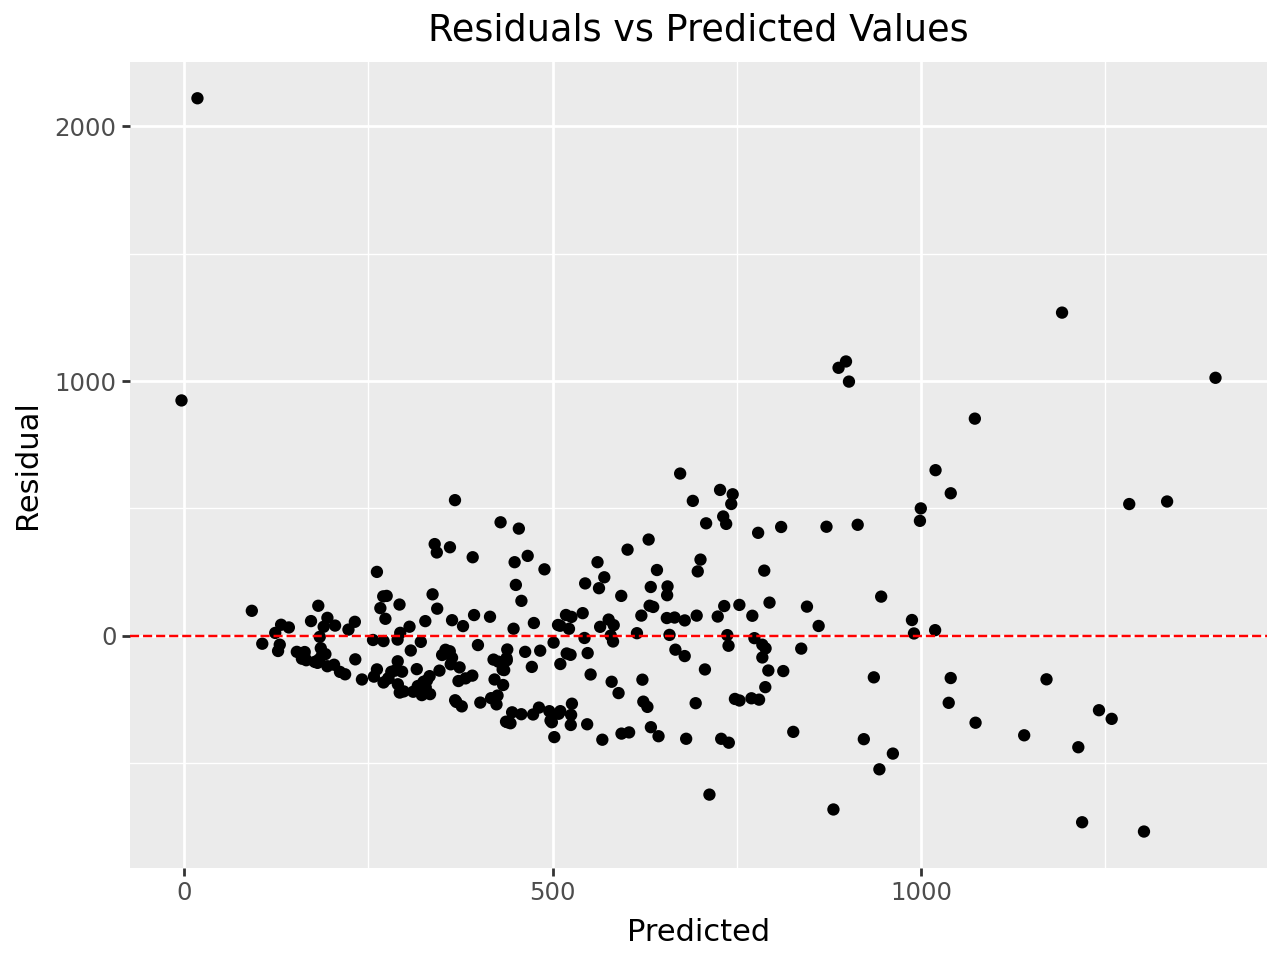

In [217]:
from plotnine import *

(ggplot(final_results_df)
 + geom_point(aes(x="Predicted", y="Residual"))
  + geom_hline(yintercept=0, linetype="dashed", color="red")
 + labs(title="Residuals vs Predicted Values", x="Predicted", y="Residual"))

This graph gives a nice visualization on how our model is doing in regards to predicting versus the actual model. We do still see a funnel shaped pattern as the predicted numbers increase which would imply that we might be able to make an even better model if we added additional predictor variables. 

Citations:

ChatGPT helped me print out the coefficients for some of the models and also helped me compare my models in the discussion section from part 3.